In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import jit

In [7]:
x_dim = 2 # dimension of observations
num_MBONS = 1
freqs = [0.5, 0.5]
mus = []

for i in range(num_MBONS+1):
    mus.append(5*np.random.randn(x_dim,1))
    
sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T
samples = 1000 # number of data points

In [8]:
mus = [np.array([[10],[0]]), np.array([[0],[10]])]

In [9]:
classes = []
for i in range(num_MBONS+1):
    classes.append(mus[i] + np.random.randn(x_dim,int(samples*freqs[i])))

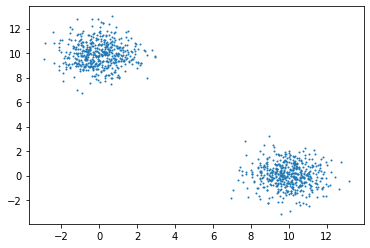

In [10]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],s=1)
plt.show()

In [11]:
num_clusters = 2
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
idx = np.random.permutation(samples)
neural = True
for t in tqdm(range(samples)):

    x = X[:,idx[t]].reshape((x_dim,1))

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = 0

    if neural:
        
        er  = 1
        itr = 1
        while er > 1e-7:
        
            z_prev = z
            y_prev = y
            
            y = np.maximum( 0, y + (eta)*( -a - z - rho*(np.sum(y) - 1) ) );
            z += eta*( np.sum(y) - 1 )
            
            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1
        
    else:
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]

    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,idx[t]] = y[j]

print(f'Cluster 1 mean: {W[0,:]/2}')
print(f'Cluster 2 mean: {W[1,:]/2}')

100%|██████████| 1000/1000 [00:39<00:00, 25.33it/s]

Cluster 1 mean: [9.94548169 0.02234277]
Cluster 2 mean: [-0.01763337  9.89203249]


In [13]:
num_clusters = 2
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
idx = np.random.permutation(samples)
neural = True
alpha = 10**-2.5
for t in tqdm(range(samples)):

    x = X[:,idx[t]].reshape((x_dim,1))

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = 0

    if neural:
        
        er  = 1
        itr = 1
        while er > 1e-7:
        
            z_prev = z
            y_prev = y
            
            y = np.maximum( 0, y + (eta)*(-alpha*t*y/n -a - z - rho*np.maximum(0,np.sum(y) - 1)) );
            z += eta*np.maximum(0,np.sum(y) - 1)
            
            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1
        
    else:
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]

    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,idx[t]] = y[j]

print(f'Cluster 1 mean: {W[0,:]/2}')
print(f'Cluster 2 mean: {W[1,:]/2}')

100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]

Cluster 1 mean: [9.93824534 0.02203912]
Cluster 2 mean: [0.44112504 9.43849654]
